In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import anndata as ad
from PIL import Image
from sklearn.cluster import KMeans
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Uploading the AnnData

In [3]:
parent_folder = os.getcwd()
subfolder_name = "adata_baroque_paintings"
file_name = "adata_baroque_paintings_trial6_complementarity.h5ad"

save_path = os.path.join(parent_folder, subfolder_name, file_name)
adata_baroque_paintings_full = sc.read_h5ad(save_path)

In [4]:
adata_baroque_paintings_full

AnnData object with n_obs × n_vars = 286 × 120
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art', 'color_complementarity_score'

In [5]:
adata_baroque_paintings_full.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20,not_sacred,not_Baroque_Art,not_Jesuit_Art,color_complementarity_score
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875,0,0,1,0.042089
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400,0,0,1,0.083127
3,Imposición de la casulla a san Ildefonso,55.0,33.0,1600,1600,Peter Paul Rubens,1,0,1,0.015918,...,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700,0,0,1,0.082595
4,La Sagrada Familia,23.0,35.0,1600,1600,Peter Paul Rubens,1,0,1,0.009649,...,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000,0,0,1,0.005416
5,Vulcano y el fuego,126.0,140.0,1600,1600,Peter Paul Rubens,0,0,1,0.012177,...,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100,1,0,1,0.003148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,La Berceuse,0.0,0.0,1888,1888,Vincent van Gogh,0,0,0,0.050316,...,0.028325,0.027550,0.027175,0.026075,0.024800,0.013250,1,1,1,0.119284
283,Self_protrait_VanGogh,0.0,0.0,1889,1889,Vincent van Gogh,0,0,0,0.053616,...,0.023825,0.023425,0.016750,0.015975,0.015425,0.013925,1,1,1,0.372845
284,Selfportrait_with_grey_felt_hat,0.0,0.0,1887,1888,Vincent van Gogh,0,0,0,0.053712,...,0.031175,0.029200,0.028050,0.025850,0.020450,0.009925,1,1,1,0.552021


# Setting up a Data Frame to Summarize the Results

In [6]:
accuracy_and_sensitivity_results =  {
    'model': ["Nearest Neighbors", "Naïve Bayes", "Logistic Regression", "Support Machine Vector", "Decision Tree", "Random Forest"],
    'accuracy_RGB_training': [0.7515, 0.6667, 0.6727, 0.7758, 0.9939, 0.9939],
    'accuracy_RGB_testing': [0.6429, 0.5714, 0.6190, 0.5952, 0.5714, 0.7381],
    'accuracy_HSV_training': [0.7455, 0.6424, 0.6848, 0.8182, 0.9939, 0.9939],
    'accuracy_HSV_testing': [0.6667, 0.6190, 0.6190, 0.6905, 0.6667, 0.7381],
    'accuracy_HSV_training_cross_validation': [0.9939, 0.6424, 0.6667, 0.7030, 0.9515, 0.9939],
    'accuracy_HSV_testing_cross_validation': [0.6429, 0.6190, 0.6905, 0.5714, 0.5292, 0.6905],
}

In [7]:
accuracy_and_sensitivity_results_df = pd.DataFrame(accuracy_and_sensitivity_results)

In [8]:
accuracy_and_sensitivity_results_df

,model,accuracy_RGB_training,accuracy_RGB_testing,accuracy_HSV_training,accuracy_HSV_testing,accuracy_HSV_training_cross_validation,accuracy_HSV_testing_cross_validation
0,Nearest Neighbors,0.7515,0.6429,0.7455,0.6667,0.9939,0.6429
1,Naïve Bayes,0.6667,0.5714,0.6424,0.6190,0.6424,0.6190
2,Logistic Regression,0.6727,0.6190,0.6848,0.6190,0.6667,0.6905
3,Support Machine Vector,0.7758,0.5952,0.8182,0.6905,0.7030,0.5714
4,Decision Tree,0.9939,0.5714,0.9939,0.6667,0.9515,0.5292
5,Random Forest,0.9939,0.7381,0.9939,0.7381,0.9939,0.6905


EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


KNeighbors Classifier Accuracy: 0.7455
KNeighbors Classifier ROC-AUC: 0.7858


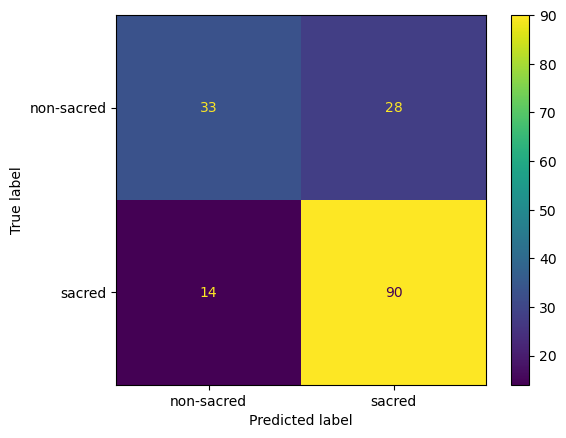

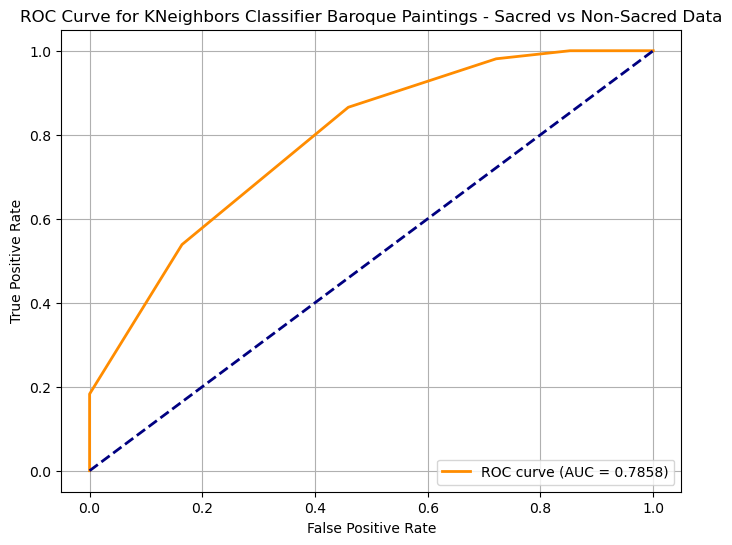

KNeighbors Classifier Sensitivity: 0.5410
-----------------------------------------


For the testing data


KNeighbors Classifier Accuracy: 0.6667
KNeighbors Classifier ROC-AUC: 0.6667


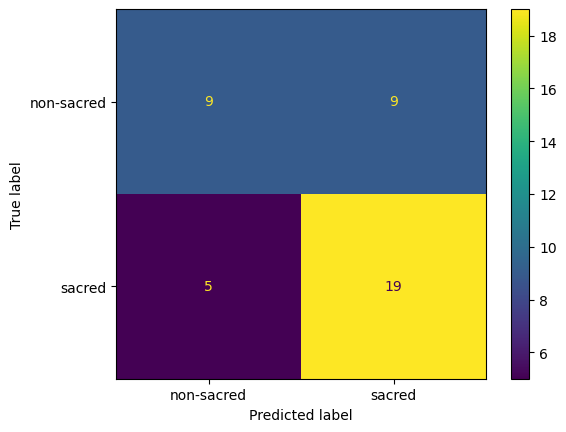

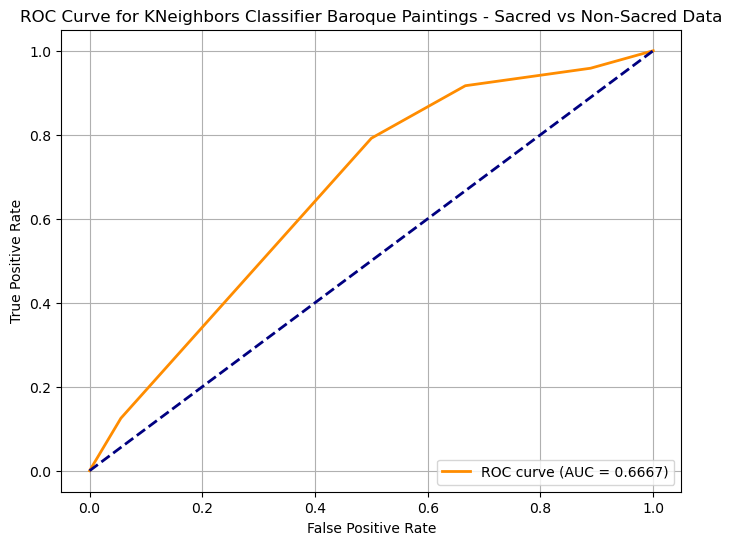

KNeighbors Classifier Sensitivity: 0.5000


In [23]:
evaluate(model = "knn",
         model_name = "KNeighbors Classifier",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Naïve Bayes Classifier Accuracy: 0.6424
Naïve Bayes Classifier ROC-AUC: 0.7156


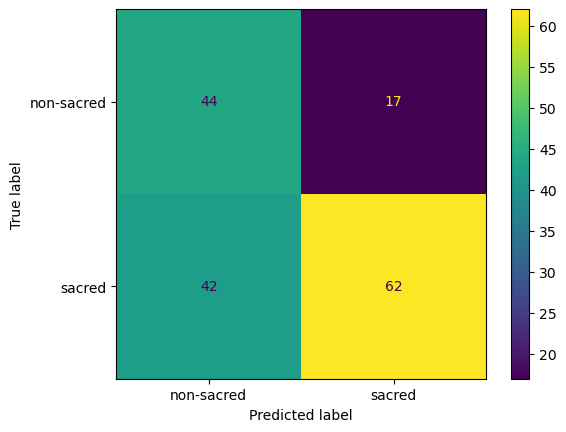

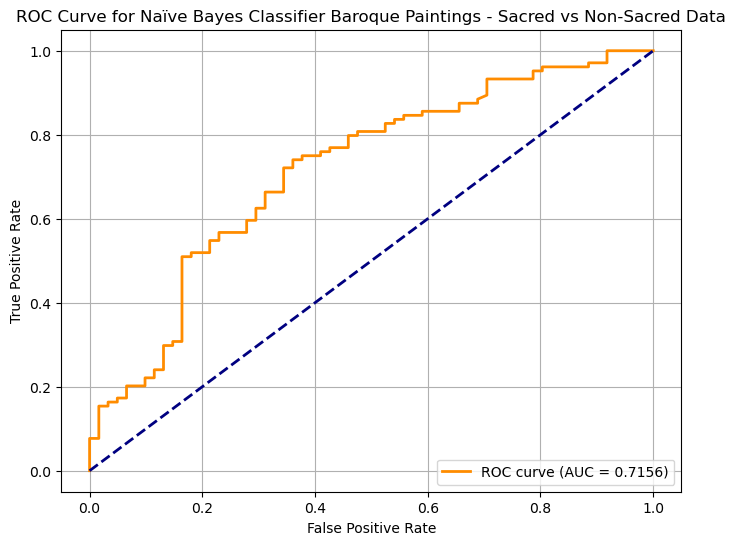

Naïve Bayes Classifier Sensitivity: 0.7213
-----------------------------------------


For the testing data


Naïve Bayes Classifier Accuracy: 0.6190
Naïve Bayes Classifier ROC-AUC: 0.6389


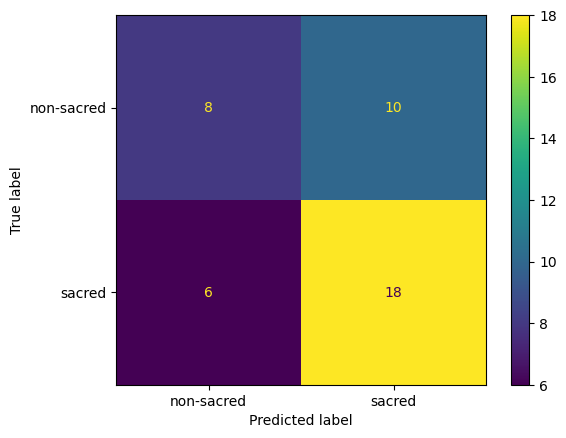

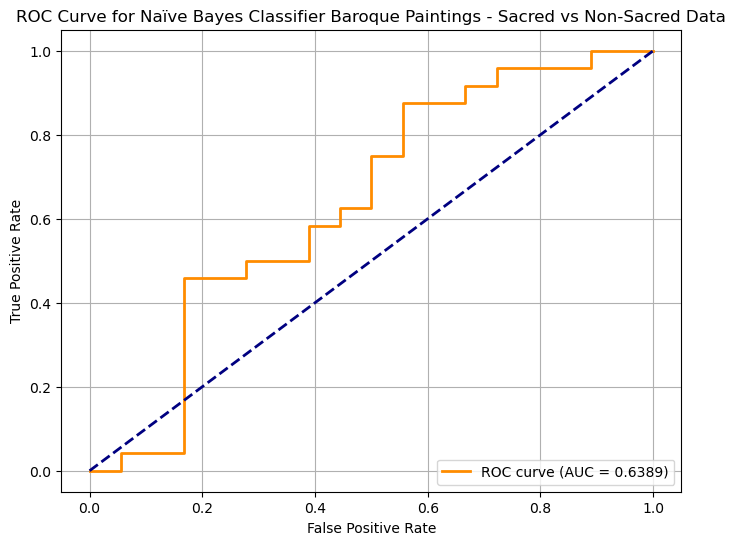

Naïve Bayes Classifier Sensitivity: 0.4444


In [24]:
evaluate(model = "naive_bayes",
         model_name = "Naïve Bayes Classifier",
         X_train = X_train,
         Y_train = Y_train_sacred,
         X_test = X_test,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Logistic Regression Classifier Accuracy: 0.6848
Logistic Regression Classifier ROC-AUC: 0.7324


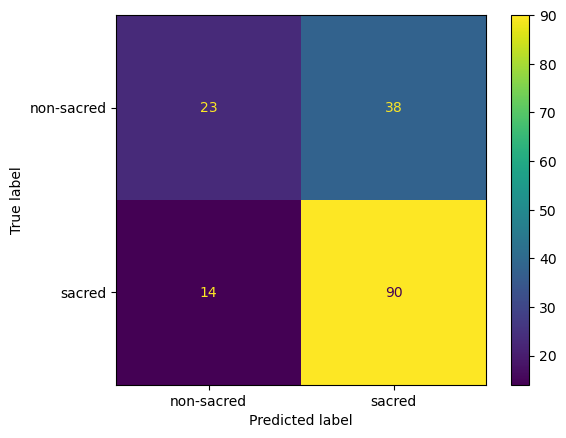

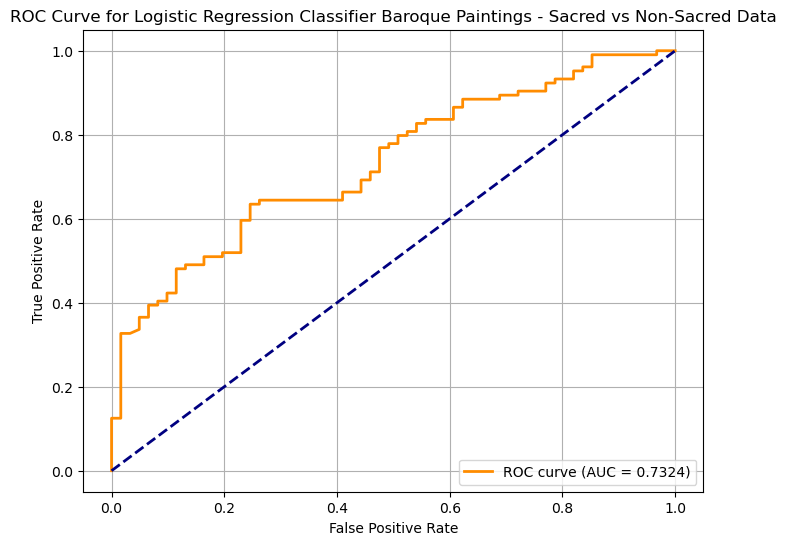

Logistic Regression Classifier Sensitivity: 0.3770
-----------------------------------------


For the testing data


Logistic Regression Classifier Accuracy: 0.6190
Logistic Regression Classifier ROC-AUC: 0.7338


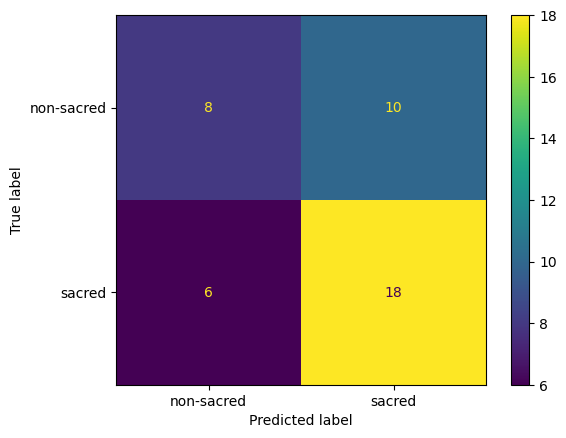

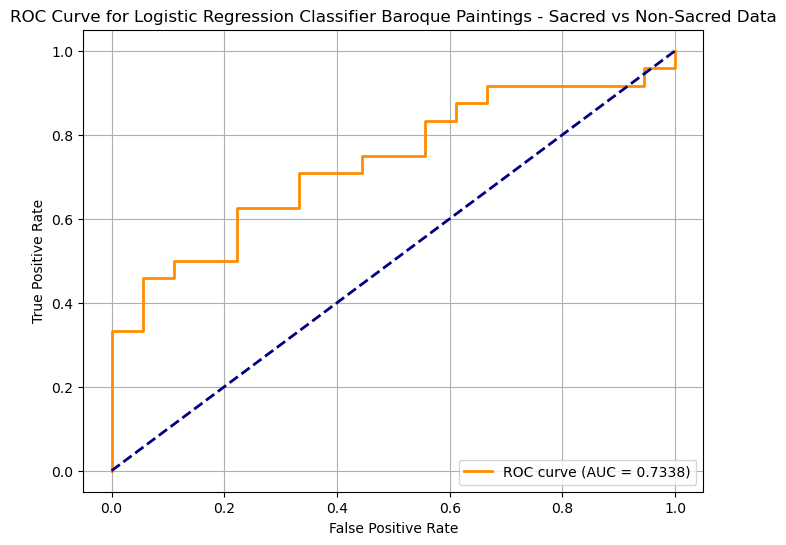

Logistic Regression Classifier Sensitivity: 0.4444


In [25]:
evaluate(model = "logistic_regression",
         model_name = "Logistic Regression Classifier",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Support Vector Machine Accuracy: 0.8182
Support Vector Machine ROC-AUC: 0.0622


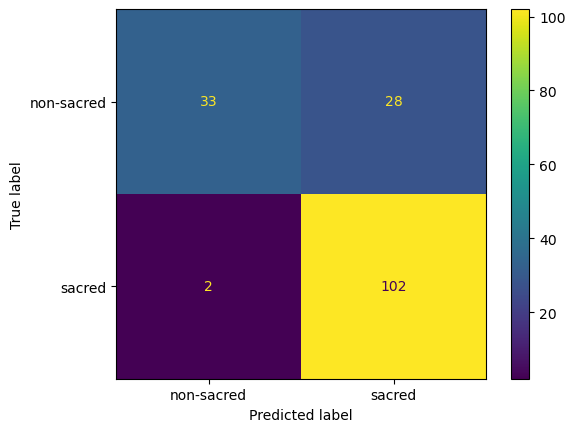

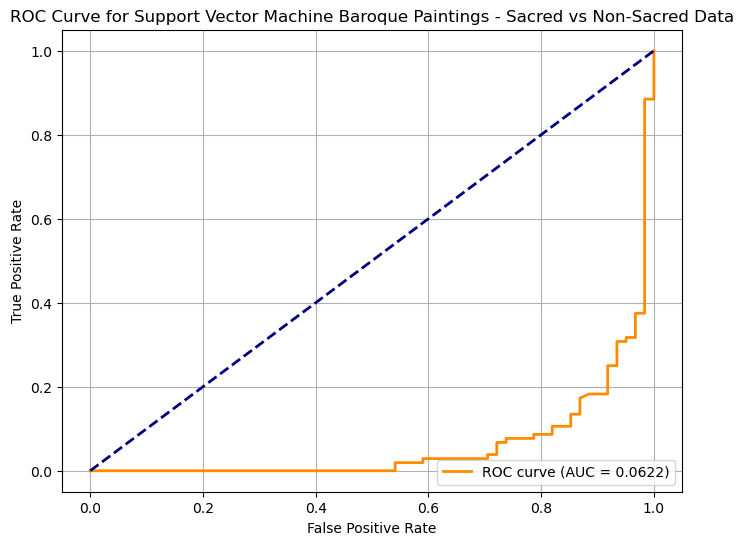

Support Vector Machine Sensitivity: 0.5410
-----------------------------------------


For the testing data


Support Vector Machine Accuracy: 0.6905
Support Vector Machine ROC-AUC: 0.2199


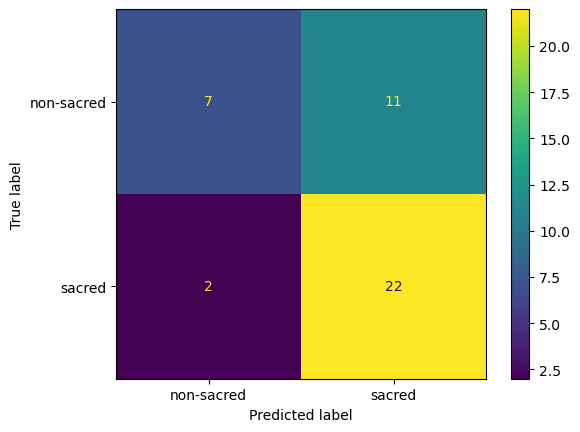

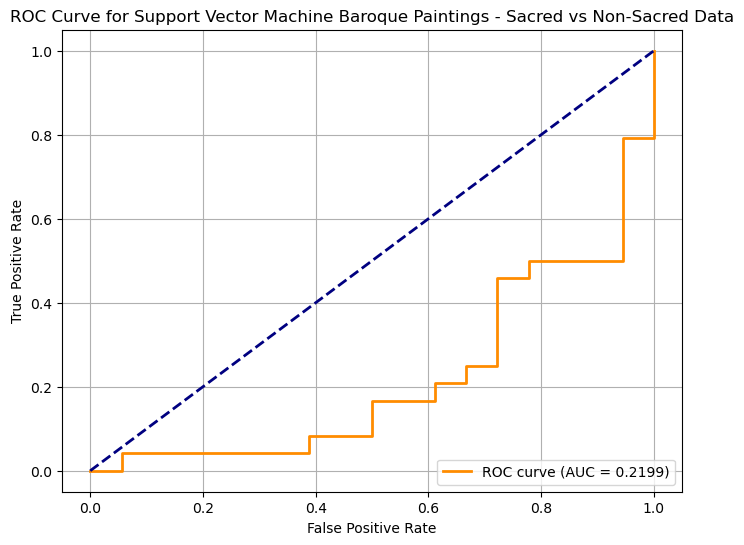

Support Vector Machine Sensitivity: 0.3889


In [26]:
evaluate(model = "svm",
         model_name = "Support Vector Machine",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Decision Tree Classifier Accuracy: 0.9939
Decision Tree Classifier ROC-AUC: 0.9999


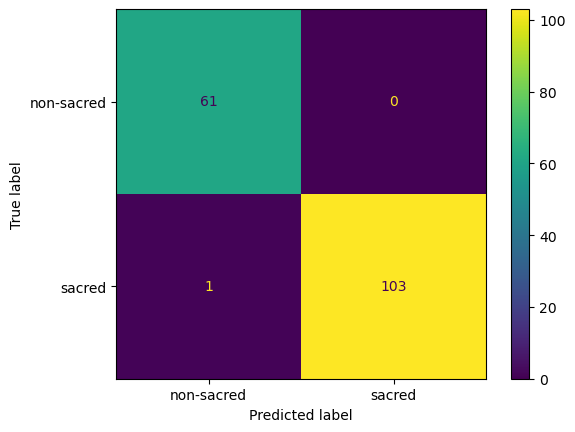

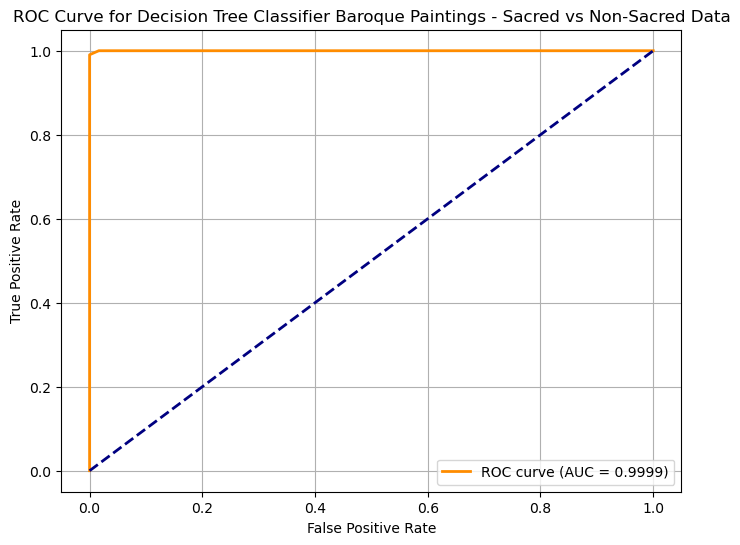

Decision Tree Classifier Sensitivity: 1.0000
-----------------------------------------


For the testing data


Decision Tree Classifier Accuracy: 0.6667
Decision Tree Classifier ROC-AUC: 0.6389


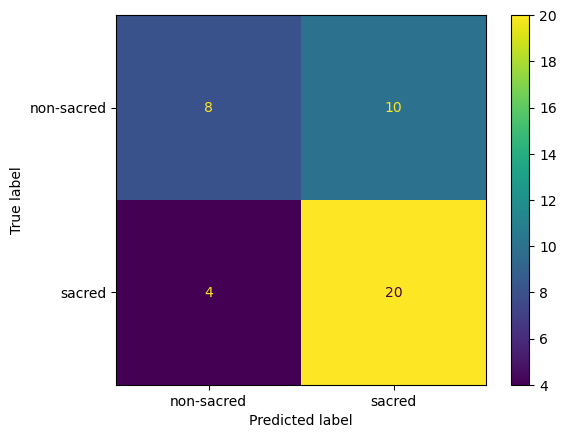

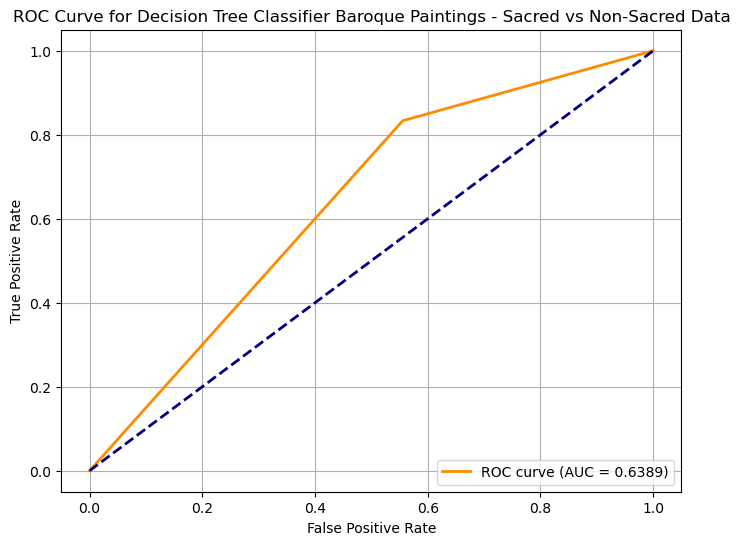

Decision Tree Classifier Sensitivity: 0.4444


In [27]:
evaluate(model = "decision_tree",
         model_name = "Decision Tree Classifier",
         X_train = X_train,
         Y_train = Y_train_sacred,
         X_test = X_test,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

In [19]:
accuracy_and_sensitivity_results_df.columns

Index(['model', 'accuracy_RGB_training', 'accuracy_RGB_testing',
       'accuracy_HSV_training', 'accuracy_HSV_testing',
       'accuracy_HSV_training_cross_validation',
       'accuracy_HSV_testing_cross_validation'],
      dtype='object')

In [20]:
df = pd.DataFrame(accuracy_and_sensitivity_results)

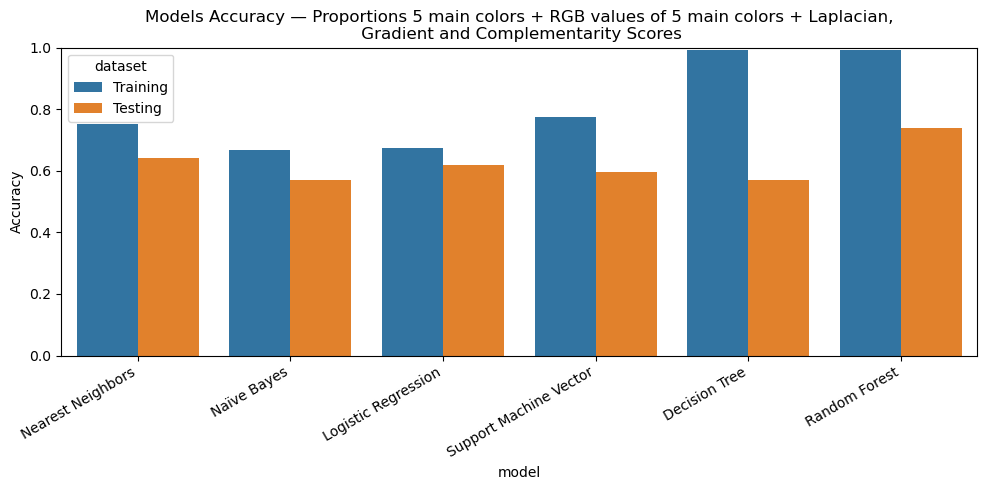

In [31]:
df_rgb = df.melt(
    id_vars="model",
    value_vars=["accuracy_RGB_training", "accuracy_RGB_testing"],
    var_name="dataset",
    value_name="accuracy"
)

df_rgb["dataset"] = df_rgb["dataset"].map({
    "accuracy_RGB_training": "Training",
    "accuracy_RGB_testing": "Testing"
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df_rgb, x="model", y="accuracy", hue="dataset")
plt.title("Models Accuracy — Proportions 5 main colors + RGB values of 5 main colors + Laplacian,\n Gradient and Complementarity Scores")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

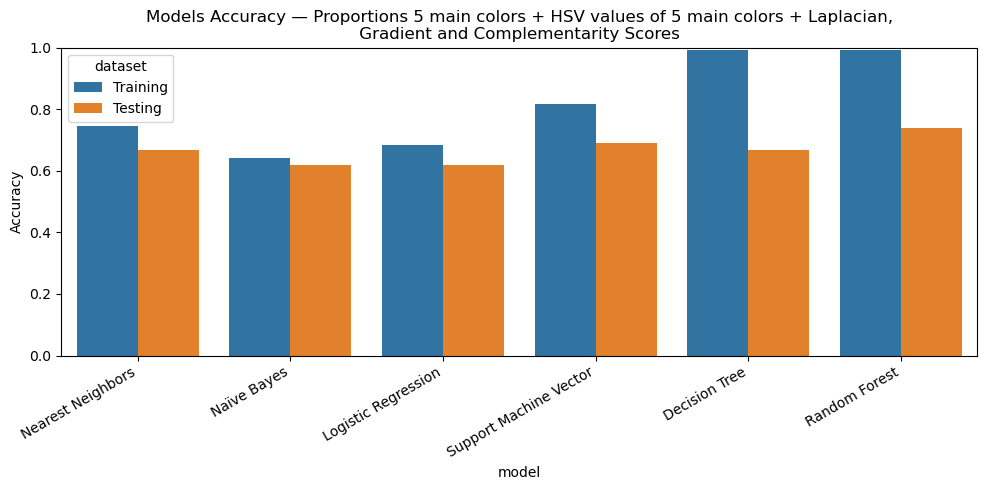

In [29]:
df_hsv = df.melt(
    id_vars="model",
    value_vars=["accuracy_HSV_training", "accuracy_HSV_testing"],
    var_name="dataset",
    value_name="accuracy"
)

df_hsv["dataset"] = df_hsv["dataset"].map({
    "accuracy_HSV_training": "Training",
    "accuracy_HSV_testing": "Testing"
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df_hsv, x="model", y="accuracy", hue="dataset")
plt.title("Models Accuracy — Proportions 5 main colors + HSV values of 5 main colors + Laplacian,\n Gradient and Complementarity Scores ")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

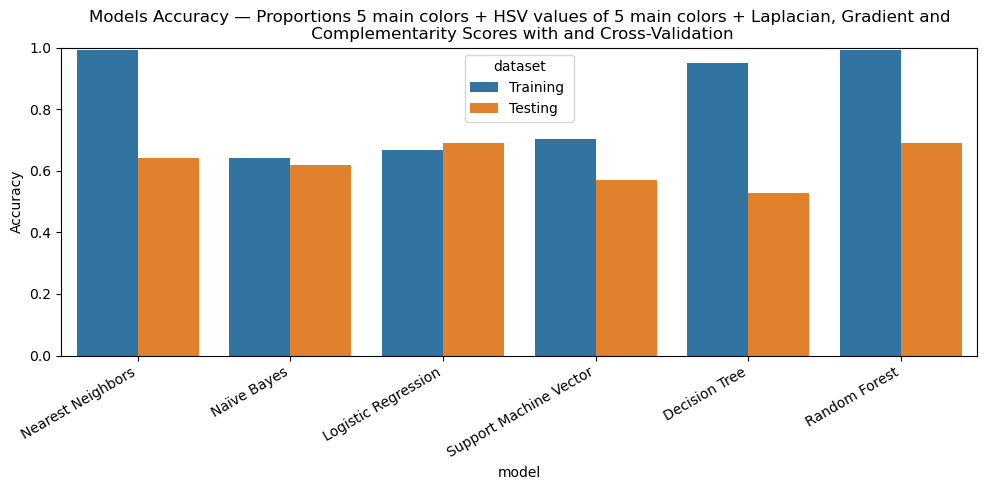

In [27]:
df_cv = df.melt(
    id_vars="model",
    value_vars=[
        "accuracy_HSV_training_cross_validation",
        "accuracy_HSV_testing_cross_validation"
    ],
    var_name="dataset",
    value_name="accuracy"
)

df_cv["dataset"] = df_cv["dataset"].map({
    "accuracy_HSV_training_cross_validation": "Training ",
    "accuracy_HSV_testing_cross_validation": "Testing "
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df_cv, x="model", y="accuracy", hue="dataset")
plt.title("Models Accuracy — Proportions 5 main colors + HSV values of 5 main colors + Laplacian, Gradient and\n Complementarity Scores with and Cross-Validation")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Best Parameters

In [33]:
best_parameters =  {
    'model': ["Original", "No Complementarity Score", "No Gradient Score", "No Gaussian Score", "No Color Proportions", "No HSV data"],
    'accuracy_training': [0.9939, 0.9939, 0.9939, 0.9939, 0.9939, 0.9939],
    'accuracy_testing': [0.7381, 0.7143, 0.6905, 0.6667, 0.7361, 0.6429],
    
}

accuracy_and_sensitivity_results_df = pd.DataFrame(best_parameters)

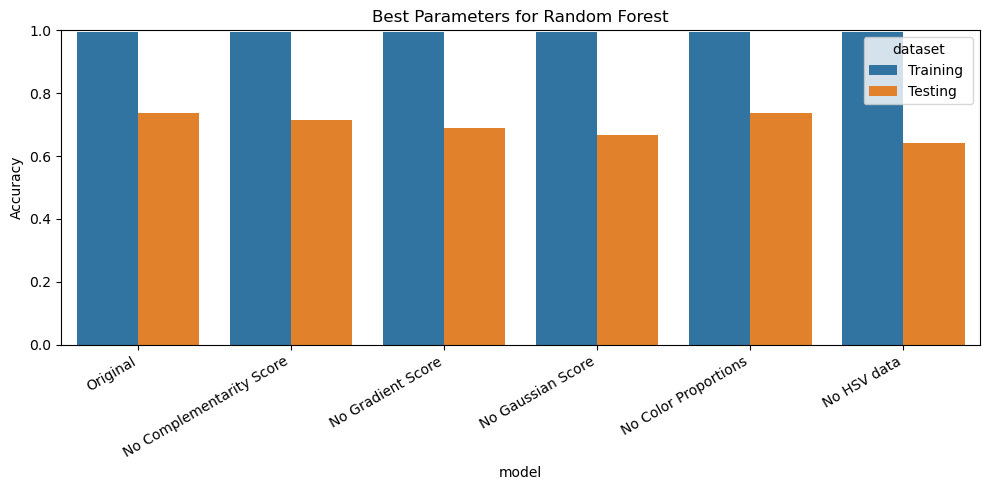

In [35]:
df_parameters = accuracy_and_sensitivity_results_df.melt(
    id_vars="model",
    value_vars=[
        "accuracy_training",
        "accuracy_testing"
    ],
    var_name="dataset",
    value_name="accuracy"
)

df_parameters["dataset"] = df_parameters["dataset"].map({
    "accuracy_training": "Training ",
    "accuracy_testing": "Testing "
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df_parameters, x="model", y="accuracy", hue="dataset")
plt.title("Best Parameters for Random Forest")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()